In [4]:
# from moku.instruments import PIDController
# from moku.instruments import Oscilloscope
from numpy import sqrt, pi, array, arange, polyfit
from scipy import optimize

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import datetime

%matplotlib notebook

In [1]:
4.51 / 5

0.9019999999999999

## Pressure conversion

In [2]:
def con_pv(voltage):
    return 10**((voltage-7.75)/0.75)

In [26]:
con_pv(2.39)

7.134003750712579e-08

## MOKU:GO oscilloscopy

In [ ]:
# This example demonstrates how you can configure the Oscilloscope instrument,
# and view triggered time-voltage data frames in real-time.
#
# (c) 2021 Liquid Instruments Pty. Ltd.

print('START : ' + datetime.datetime.now().strftime("%d/%m/%Y, %H:%M:%S"))
def on_close(event):
    print('Closed Figure!')
    i.relinquish_ownership()
    
# Connect to your Moku by its ip address using Oscilloscope('192.168.###.###')
# or by its serial number using Oscilloscope(serial=123)
i = Oscilloscope('129.206.180.142', force_connect=True)

try:
    # Trigger on input Channel 1, rising edge, 0V 
    i.set_trigger(type='Edge', source='Input1', level=0)

    # View +-5usec, i.e. trigger in the centre
    i.set_timebase(-5e-6, 5e-6)

    # Generate an output sine wave on Channel 1, 1Vpp, 1MHz, 0V offset
    # i.generate_waveform(1, 'DC', amplitude=1)
    # i.generate_waveform(2, 'Sine', amplitude=1, frequency=1e6)

    # Set the data source of Channel 1 to be Input 1
    i.set_source(1, 'Input1')

    # Set the data source of Channel 2 to the generated output sinewave
    i.set_source(2, 'Input2')


    # Get initial data frame to set up plotting parameters. This can be done
    # once if we know that the axes aren't going to change (otherwise we'd do
    # this in the loop)
    data = i.get_data()
    print(data.keys())

    # Set up the plotting parameters
    plt.ion()
    plt.show()
    plt.grid(b=True)
    plt.ylim([-1, 1])
    plt.xlim([data['time'][0], data['time'][-1]])

    line1, = plt.plot([], label='channel 1')
    line2, = plt.plot([], label='channel 2')

    # Configure labels for axes
    ax = plt.gca()
    
    # This loops continuously updates the plot with new data
    while True:
        # Get new data
        data = i.get_data()

        # Update the plot
        line1.set_ydata(data['ch1'])
        line2.set_ydata(data['ch2'])
        line1.set_xdata(data['time'])
        line2.set_xdata(data['time'])
        
        ax.set_title(datetime.datetime.now().strftime("%d/%m/%Y, %H:%M:%S"))
        ax.legend()

        plt.pause(0.001)
        
        fig = plt.gcf()  # get current figure
        fig.canvas.mpl_connect('close_event', on_close)
        
except Exception as e:
    print(f'Exception occurred: {e}')
except KeyboardInterrupt:
    print('Interrupt!')
finally:
    # Close the connection to the Moku device
    # This ensures network resources and released correctly
    i.relinquish_ownership()
    print('Ownership relinquished!')

In [ ]:
i.relinquish_ownership()

## Power calibration

In [5]:
# define functions for fitting
def exp(x, a, b, c, t):
    return a * np.exp(-t * x + b) + c

[10.10023318 -2.45641193 -0.8797924  -0.61053745]


<IPython.core.display.Javascript object>


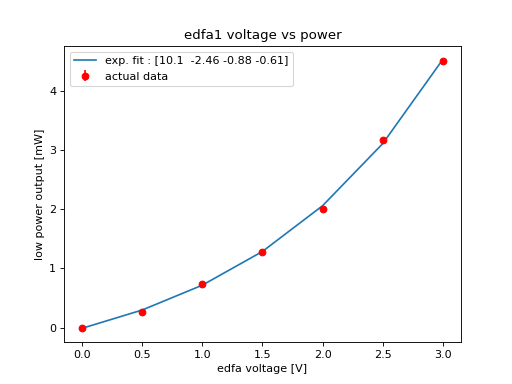

[-0.01377772  0.29538052  0.71490504  1.28419546  2.05671664  3.10501985
  4.52755642]


In [6]:
edfa = np.arange(0, 3.1, 0.5)
power_low = np.array([0,0.27,0.74,1.28,2.01,3.16,4.51])
perr = np.array([0.01]*7)

popt, pcov = optimize.curve_fit(exp, edfa, power_low, sigma=perr, p0=[5, -1, -5, -1])
label = 'exp. fit : ' + str(np.round(popt,2))
print(popt)

fig, ax = plt.subplots()

ax.errorbar(edfa, power_low, yerr=perr, fmt='ro', label='actual data')
ax.plot(edfa, exp(edfa, *popt), label=label)
print(exp(edfa, *popt),)

ax.set_title('edfa1 voltage vs power')
ax.set_xlabel('edfa voltage [V]')
ax.set_ylabel('low power output [mW]')
ax.legend()